In [1]:
import pandas as pd

# ========================
# Full Corner Classification Script
# ========================

def classify_corner_sequences(file_path):
    # Load Excel file
    print(f"Loading file: {file_path}")
    df = pd.read_excel(file_path)

    # Sort events chronologically
    if 'index' in df.columns:
        df = df.sort_values(by='index').reset_index(drop=True)
    elif 'event_id' in df.columns:
        df = df.sort_values(by='event_id').reset_index(drop=True)
    else:
        raise ValueError("No time-order column found. Please ensure 'index' or 'event_id' is in your dataset.")

    # Ensure timestamp is timedelta
    if not pd.api.types.is_timedelta64_dtype(df['timestamp']):
        try:
            df['timestamp'] = pd.to_timedelta(df['timestamp'])
        except Exception as e:
            raise ValueError("Timestamp column could not be converted to timedelta.") from e

    # Step 1: Filter passes from corners
    corner_passes = df[
        (df['type.name'] == 'Pass') &
        (df['play_pattern.name'] == 'From Corner') &
        (df['pass.type.name'] == 'Corner')
    ]

    if corner_passes.empty:
        print("No corner passes found in the dataset.")
        return pd.DataFrame()

    results = []

    for idx, row in corner_passes.iterrows():
        start_index = idx
        start_team = row['possession_team.id']

        # Determine corner side (left/right)
        if 'location' in row and isinstance(row['location'], (list, tuple)) and len(row['location']) >= 1:
            # Example: assume pitch width is 120 units (adjust if necessary)
            side = 'Left' if row['location'][0] < 60 else 'Right'
        else:
            side = 'Unknown'

        # Extract pass details
        pass_height = row.get('pass.height.name', 'Unknown')
        pass_body_part = row.get('pass.body_part.name', 'Unknown')
        pass_outcome = row.get('pass.outcome.name', 'Unknown')
        pass_technique = row.get('pass.technique.name', 'Unknown')

        # Get all subsequent events
        subsequent_events = df.iloc[start_index + 1:]

        # Filter events while possession remains the same
        same_possession = subsequent_events[
            subsequent_events['possession_team.id'] == start_team
        ]

        if same_possession.empty:
            # No first contact
            results.append({
                'corner_index': idx,
                'classification': 'No first contact - no shot',
                'side': side,
                'pass_height': pass_height,
                'pass_body_part': pass_body_part,
                'pass_outcome': pass_outcome,
                'pass_technique': pass_technique
            })
            continue

        # First contact: first event after corner within the same possession
        first_contact = same_possession.iloc[0]

        if first_contact['type.name'] == 'Shot':
            classification = 'First contact - direct shot'
        else:
            # Look for shot within 3 seconds of first contact
            shot_within_3_sec = same_possession[
                (same_possession['type.name'] == 'Shot') &
                ((same_possession['timestamp'] - first_contact['timestamp']).dt.total_seconds() <= 3)
            ]

            if not shot_within_3_sec.empty:
                classification = 'First contact - shot within 3 seconds'
            else:
                # Check if any shot at all before possession changes
                any_shot = same_possession[same_possession['type.name'] == 'Shot']

                if not any_shot.empty:
                    classification = 'No first contact - shot'
                else:
                    classification = 'First contact - no shot'

        results.append({
            'corner_index': idx,
            'classification': classification,
            'side': side,
            'pass_height': pass_height,
            'pass_body_part': pass_body_part,
            'pass_outcome': pass_outcome,
            'pass_technique': pass_technique
        })

    # Create summary DataFrame
    summary_df = pd.DataFrame(results)

    # Show result counts
    print("\nClassification Summary:")
    print(summary_df['classification'].value_counts())
    print("\nDetailed Results:")
    print(summary_df)

    return summary_df


# ========================
# Run the script
# ========================

if __name__ == "__main__":
    # Specify your Excel file name here
    file_path = '/Users/user/Tesy/events_match_3949488.xlsx'  # Replace with your actual file path

    # Run the classification
    summary = classify_corner_sequences(file_path)

    # Save the results to Excel
    summary.to_excel('corner_classification_results.xlsx', index=False)
    print("\nResults saved to 'corner_classification_results.xlsx'")


Loading file: /Users/user/Tesy/events_match_3949488.xlsx

Classification Summary:
classification
First contact - shot within 3 seconds    8
No first contact - shot                  5
First contact - no shot                  1
Name: count, dtype: int64

Detailed Results:
    corner_index                         classification     side  pass_height  \
0            160                No first contact - shot  Unknown    High Pass   
1            365                No first contact - shot  Unknown    High Pass   
2            408                No first contact - shot  Unknown    High Pass   
3            470  First contact - shot within 3 seconds  Unknown    High Pass   
4            616  First contact - shot within 3 seconds  Unknown    High Pass   
5           1031  First contact - shot within 3 seconds  Unknown    High Pass   
6           1199  First contact - shot within 3 seconds  Unknown  Ground Pass   
7           1946  First contact - shot within 3 seconds  Unknown    High Pass   


Loading file: /Users/user/Tesy/events_match_3949488.xlsx

Classification Summary:
classification
First contact - shot within 3 seconds    8
No first contact - shot                  5
First contact - no shot                  1
Name: count, dtype: int64

Results saved to 'corner_classification_results.xlsx'


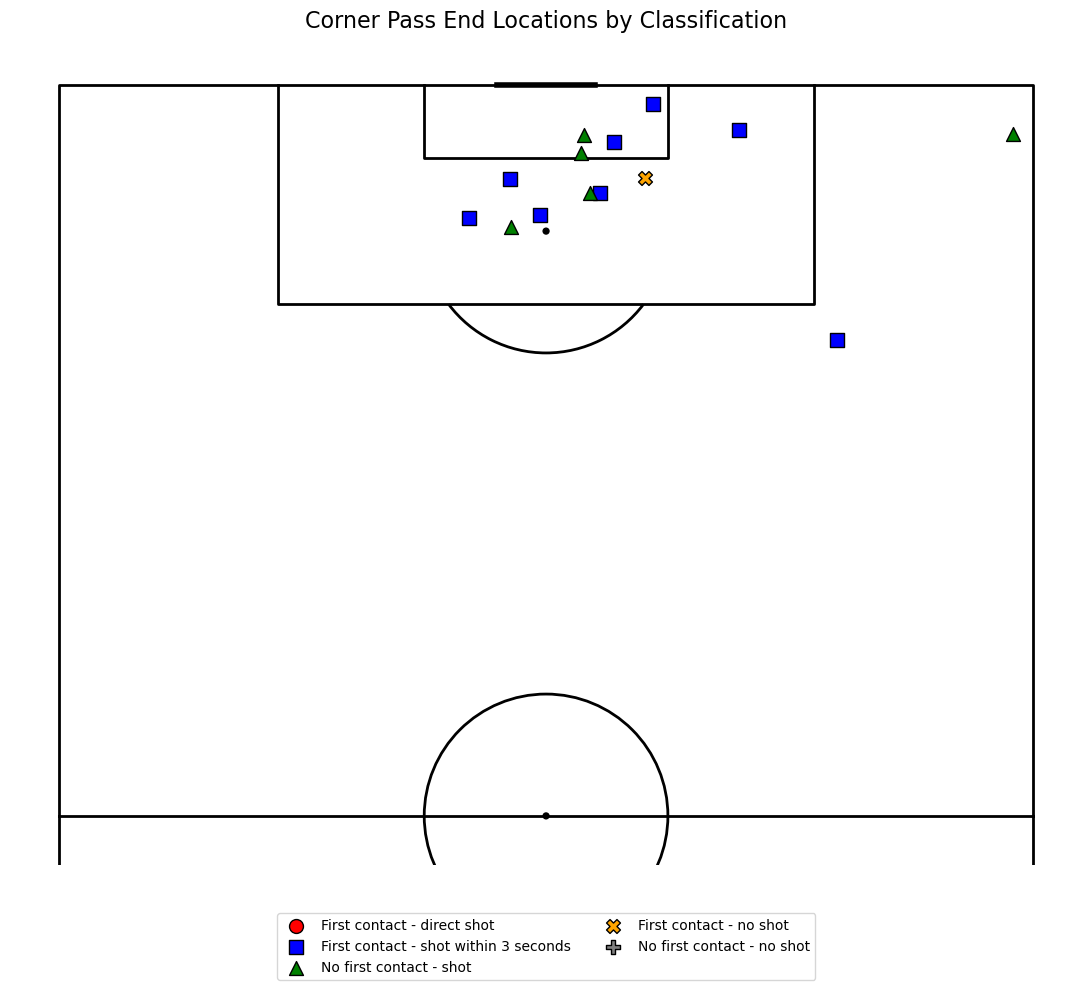

In [7]:
import pandas as pd
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

def classify_corner_sequences(file_path):
    # Load Excel file
    print(f"Loading file: {file_path}")
    df = pd.read_excel(file_path)

    # Split pass.end_location into two float columns
    df[['pass_end_x', 'pass_end_y']] = df['pass.end_location'].str.split(',', expand=True).astype(float)

    # Sort events chronologically
    if 'index' in df.columns:
        df = df.sort_values(by='index').reset_index(drop=True)
    elif 'event_id' in df.columns:
        df = df.sort_values(by='event_id').reset_index(drop=True)
    else:
        raise ValueError("No time-order column found. Please ensure 'index' or 'event_id' is in your dataset.")

    # Ensure timestamp is timedelta
    if not pd.api.types.is_timedelta64_dtype(df['timestamp']):
        try:
            df['timestamp'] = pd.to_timedelta(df['timestamp'])
        except Exception as e:
            raise ValueError("Timestamp column could not be converted to timedelta.") from e

    # Step 1: Filter passes from corners
    corner_passes = df[
        (df['type.name'] == 'Pass') &
        (df['play_pattern.name'] == 'From Corner') &
        (df['pass.type.name'] == 'Corner')
    ]

    if corner_passes.empty:
        print("No corner passes found in the dataset.")
        return pd.DataFrame()

    results = []

    for idx, row in corner_passes.iterrows():
        start_index = idx
        start_team = row['possession_team.id']

        # Determine corner side (left/right)
        if 'location' in row and isinstance(row['location'], (list, tuple)) and len(row['location']) >= 1:
            side = 'Left' if row['location'][0] < 60 else 'Right'
        else:
            side = 'Unknown'

        # Extract pass details
        pass_height = row.get('pass.height.name', 'Unknown')
        pass_body_part = row.get('pass.body_part.name', 'Unknown')
        pass_outcome = row.get('pass.outcome.name', 'Unknown')
        pass_technique = row.get('pass.technique.name', 'Unknown')

        # Get all subsequent events
        subsequent_events = df.iloc[start_index + 1:]

        # Filter events while possession remains the same
        same_possession = subsequent_events[
            subsequent_events['possession_team.id'] == start_team
        ]

        if same_possession.empty:
            classification = 'No first contact - no shot'
            results.append({
                'corner_index': idx,
                'classification': classification,
                'side': side,
                'pass_height': pass_height,
                'pass_body_part': pass_body_part,
                'pass_outcome': pass_outcome,
                'pass_technique': pass_technique,
                'pass_end_x': row['pass_end_x'],
                'pass_end_y': row['pass_end_y']
            })
            continue

        first_contact = same_possession.iloc[0]

        if first_contact['type.name'] == 'Shot':
            classification = 'First contact - direct shot'
        else:
            shot_within_3_sec = same_possession[
                (same_possession['type.name'] == 'Shot') &
                ((same_possession['timestamp'] - first_contact['timestamp']).dt.total_seconds() <= 3)
            ]

            if not shot_within_3_sec.empty:
                classification = 'First contact - shot within 3 seconds'
            else:
                any_shot = same_possession[same_possession['type.name'] == 'Shot']

                if not any_shot.empty:
                    classification = 'No first contact - shot'
                else:
                    classification = 'First contact - no shot'

        results.append({
            'corner_index': idx,
            'classification': classification,
            'side': side,
            'pass_height': pass_height,
            'pass_body_part': pass_body_part,
            'pass_outcome': pass_outcome,
            'pass_technique': pass_technique,
            'pass_end_x': row['pass_end_x'],
            'pass_end_y': row['pass_end_y']
        })

    summary_df = pd.DataFrame(results)

    print("\nClassification Summary:")
    print(summary_df['classification'].value_counts())

    return summary_df

# ========================
# Plotting Function
# ========================

def plot_corner_passes(summary_df):
    pitch = VerticalPitch(half=True, pitch_type='statsbomb', line_color='black')
    fig, ax = pitch.draw(figsize=(12, 10))

    # Define markers for each classification
    markers = {
        'First contact - direct shot': 'o',
        'First contact - shot within 3 seconds': 's',
        'No first contact - shot': '^',
        'First contact - no shot': 'X',
        'No first contact - no shot': 'P'
    }

    colors = {
        'First contact - direct shot': 'red',
        'First contact - shot within 3 seconds': 'blue',
        'No first contact - shot': 'green',
        'First contact - no shot': 'orange',
        'No first contact - no shot': 'gray'
    }

    for classification, marker in markers.items():
        subset = summary_df[summary_df['classification'] == classification]

        x = subset['pass_end_x']
        y = subset['pass_end_y']

        pitch.scatter(x, y, ax=ax, marker=marker, color=colors[classification], label=classification, s=100, edgecolors='black')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    plt.title('Corner Pass End Locations by Classification', fontsize=16)
    plt.savefig('corner_pass_end_locations.png', bbox_inches='tight', dpi=300)  # Save as PNG file
    plt.show()

# ========================
# Run the Full Pipeline
# ========================

if __name__ == "__main__":
    file_path = '/Users/user/Tesy/events_match_3949488.xlsx'  # Replace with your actual file path

    # Run classification
    summary = classify_corner_sequences(file_path)

    # Save results
    summary.to_excel('corner_classification_results.xlsx', index=False)
    print("\nResults saved to 'corner_classification_results.xlsx'")

    # Plot the passes
    plot_corner_passes(summary)


Loading file: /Users/user/Tesy/events_match_3949488.xlsx

Classification Summary:
classification
First contact - shot within 3 seconds    8
No first contact - shot                  5
First contact - no shot                  1
Name: count, dtype: int64

Results saved to 'corner_classification_results.xlsx'


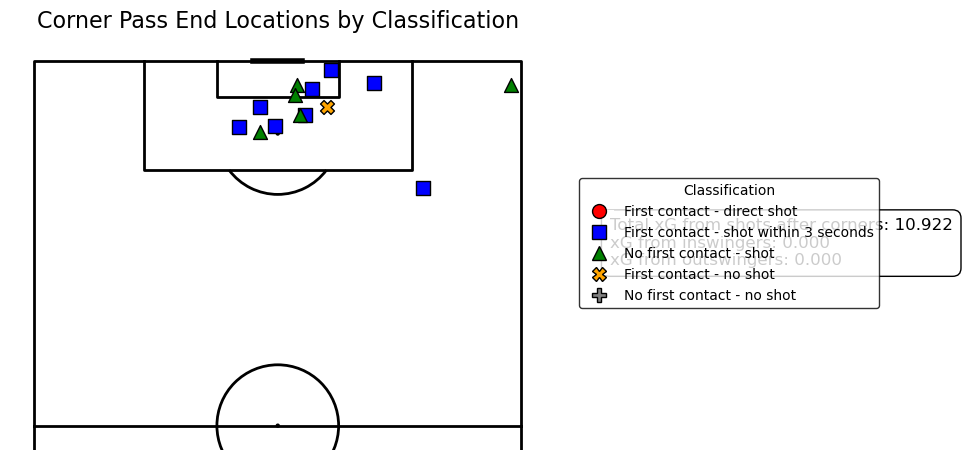

In [14]:
import pandas as pd
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

def classify_corner_sequences(file_path):
    # Load Excel file
    print(f"Loading file: {file_path}")
    df = pd.read_excel(file_path)

    # Split pass.end_location into two float columns
    df[['pass_end_x', 'pass_end_y']] = df['pass.end_location'].str.split(',', expand=True).astype(float)

    # Sort events chronologically
    if 'index' in df.columns:
        df = df.sort_values(by='index').reset_index(drop=True)
    elif 'event_id' in df.columns:
        df = df.sort_values(by='event_id').reset_index(drop=True)
    else:
        raise ValueError("No time-order column found. Please ensure 'index' or 'event_id' is in your dataset.")

    # Ensure timestamp is timedelta
    if not pd.api.types.is_timedelta64_dtype(df['timestamp']):
        try:
            df['timestamp'] = pd.to_timedelta(df['timestamp'])
        except Exception as e:
            raise ValueError("Timestamp column could not be converted to timedelta.") from e

    # Step 1: Filter passes from corners
    corner_passes = df[
        (df['type.name'] == 'Pass') &
        (df['play_pattern.name'] == 'From Corner') &
        (df['pass.type.name'] == 'Corner')
    ]

    if corner_passes.empty:
        print("No corner passes found in the dataset.")
        return pd.DataFrame()

    results = []

    for idx, row in corner_passes.iterrows():
        start_index = idx
        start_team = row['possession_team.id']

        # Determine corner side (left/right)
        if 'location' in row and isinstance(row['location'], (list, tuple)) and len(row['location']) >= 1:
            side = 'Left' if row['location'][0] < 60 else 'Right'
        else:
            side = 'Unknown'

        # Extract pass details
        pass_height = row.get('pass.height.name', 'Unknown')
        pass_body_part = row.get('pass.body_part.name', 'Unknown')
        pass_outcome = row.get('pass.outcome.name', 'Unknown')
        pass_technique = row.get('pass.technique.name', 'Unknown')

        # Get all subsequent events
        subsequent_events = df.iloc[start_index + 1:]

        # Filter events while possession remains the same
        same_possession = subsequent_events[
            subsequent_events['possession_team.id'] == start_team
        ]

        if same_possession.empty:
            classification = 'No first contact - no shot'
            results.append({
                'corner_index': idx,
                'classification': classification,
                'side': side,
                'pass_height': pass_height,
                'pass_body_part': pass_body_part,
                'pass_outcome': pass_outcome,
                'pass_technique': pass_technique,
                'pass_end_x': row['pass_end_x'],
                'pass_end_y': row['pass_end_y']
            })
            continue

        first_contact = same_possession.iloc[0]

        if first_contact['type.name'] == 'Shot':
            classification = 'First contact - direct shot'
        else:
            shot_within_3_sec = same_possession[
                (same_possession['type.name'] == 'Shot') &
                ((same_possession['timestamp'] - first_contact['timestamp']).dt.total_seconds() <= 3)
            ]

            if not shot_within_3_sec.empty:
                classification = 'First contact - shot within 3 seconds'
            else:
                any_shot = same_possession[same_possession['type.name'] == 'Shot']

                if not any_shot.empty:
                    classification = 'No first contact - shot'
                else:
                    classification = 'First contact - no shot'

        results.append({
            'corner_index': idx,
            'classification': classification,
            'side': side,
            'pass_height': pass_height,
            'pass_body_part': pass_body_part,
            'pass_outcome': pass_outcome,
            'pass_technique': pass_technique,
            'pass_end_x': row['pass_end_x'],
            'pass_end_y': row['pass_end_y']
        })

    summary_df = pd.DataFrame(results)

    print("\nClassification Summary:")
    print(summary_df['classification'].value_counts())

    return df, summary_df

def calculate_xg_stats(df, summary_df):
    xg_total = 0.0
    xg_inswinger = 0.0
    xg_outswinger = 0.0
    xg_per_corner = []

    for idx, row in summary_df.iterrows():
        corner_index = row['corner_index']
        possession_team = df.loc[corner_index, 'possession_team.id']

        # Events after corner
        subsequent_events = df.iloc[corner_index + 1:]

        # Events in same possession
        same_possession = subsequent_events[
            subsequent_events['possession_team.id'] == possession_team
        ]

        # Sum xG from shots in possession
        shots = same_possession[same_possession['type.name'] == 'Shot']
        corner_xg = shots['shot.statsbomb_xg'].sum()
        xg_per_corner.append(corner_xg)
        xg_total += corner_xg

        # Aggregate by inswinger or outswinger only if string
        pass_technique = row['pass_technique']
        if isinstance(pass_technique, str):
            if pass_technique.lower() == 'inswinger':
                xg_inswinger += corner_xg
            elif pass_technique.lower() == 'outswinger':
                xg_outswinger += corner_xg

    summary_df['xg_per_corner'] = xg_per_corner
    return xg_total, xg_inswinger, xg_outswinger

def plot_corner_passes(summary_df, xg_total, xg_inswinger, xg_outswinger):
    pitch = VerticalPitch(half=True, pitch_type='statsbomb', line_color='black')
    fig, ax = pitch.draw(figsize=(12, 10))

    markers = {
        'First contact - direct shot': 'o',
        'First contact - shot within 3 seconds': 's',
        'No first contact - shot': '^',
        'First contact - no shot': 'X',
        'No first contact - no shot': 'P'
    }
    colors = {
        'First contact - direct shot': 'red',
        'First contact - shot within 3 seconds': 'blue',
        'No first contact - shot': 'green',
        'First contact - no shot': 'orange',
        'No first contact - no shot': 'gray'
    }

    for classification, marker in markers.items():
        subset = summary_df[summary_df['classification'] == classification]

        x = subset['pass_end_x']
        y = subset['pass_end_y']

        pitch.scatter(x, y, ax=ax, marker=marker, color=colors[classification], label=classification, s=100, edgecolors='black')

    # Create legend outside pitch on the right
    handles = [Line2D([0], [0], marker=m, color='w', label=cls,
                      markerfacecolor=colors[cls], markeredgecolor='black', markersize=10) 
               for cls, m in markers.items()]
    leg = ax.legend(handles=handles, title="Classification", loc='center left', bbox_to_anchor=(1.05, 0.5))
    leg.get_frame().set_edgecolor('black')

    # Add xG stats text below legend nicely aligned
    stats_text = (
        f'Total xG from shots after corners: {xg_total:.3f}\n'
        f'xG from inswingers: {xg_inswinger:.3f}\n'
        f'xG from outswingers: {xg_outswinger:.3f}'
    )
    # Place text to right of legend
    plt.text(1.12, 0.5, stats_text, transform=ax.transAxes, fontsize=12,
             verticalalignment='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    plt.title('Corner Pass End Locations by Classification', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on right for legend and stats
    plt.show()

if __name__ == "__main__":
    file_path = '/Users/user/Tesy/events_match_3949488.xlsx'  # Replace with your actual path

    df, summary = classify_corner_sequences(file_path)
    if summary.empty:
        print("No corner passes classified - exiting.")
    else:
        xg_total, xg_inswinger, xg_outswinger = calculate_xg_stats(df, summary)
        summary.to_excel('corner_classification_results.xlsx', index=False)
        print("\nResults saved to 'corner_classification_results.xlsx'")
        plot_corner_passes(summary, xg_total, xg_inswinger, xg_outswinger)
